### Importing Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import os

### Importing Dataset

In [2]:
df = pd.read_csv("../dataset/clean_data_video_games.csv")

### Feature Selection

In [4]:
features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
X = df[features]

In [5]:
X

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,7.02,9.09,0.98,3.96
1,9.66,5.14,0.06,1.41
2,3.96,6.31,0.38,1.97
3,6.73,2.56,0.04,0.91
4,4.10,3.63,0.38,1.25
...,...,...,...,...
970,0.00,0.01,0.00,0.00
971,0.00,0.01,0.00,0.00
972,0.00,0.01,0.00,0.00
973,0.01,0.00,0.00,0.00


### Normalization

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Using the elbow method to find the optimal number of clusters

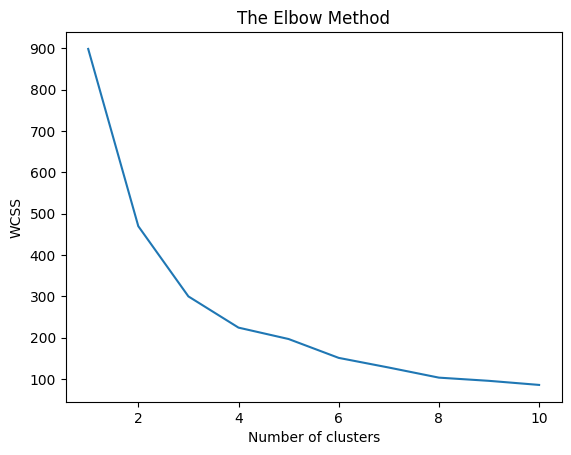

In [18]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Modelling (K-Means)

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

### Profiling

In [14]:
print("\n=== PROFIL RATA-RATA PENJUALAN PER CLUSTER ===")
profile = df.groupby('Cluster')[features].mean()
display(profile)


=== PROFIL RATA-RATA PENJUALAN PER CLUSTER ===


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Cluster,,,,
0,1.308990,1.078283,0.205556,0.359091
1,3.651818,4.901818,0.225455,1.501818
2,0.154844,0.132832,0.030647,0.038301


In [16]:
print("\nJumlah Game per Cluster:")
print(df['Cluster'].value_counts())


Jumlah Game per Cluster:
Cluster
2    865
0     99
1     11
Name: count, dtype: int64


### Visualization

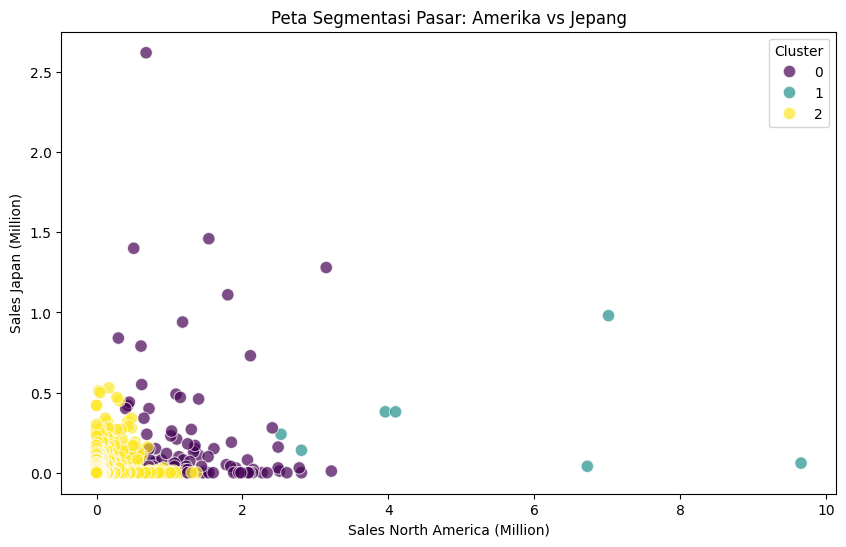

In [21]:
plt.figure(figsize=(10, 6))
# Sumbu X: Penjualan Amerika, Sumbu Y: Penjualan Jepang
sns.scatterplot(data=df, x='NA_Sales', y='JP_Sales', hue='Cluster', palette='viridis', s=80, alpha=0.7)
plt.title('Peta Segmentasi Pasar: Amerika vs Jepang')
plt.xlabel('Sales North America (Million)')
plt.ylabel('Sales Japan (Million)')
plt.show()

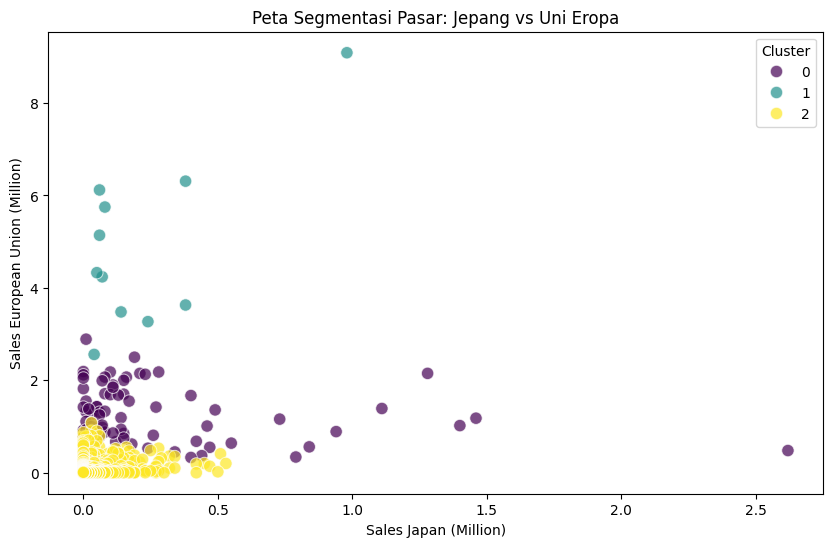

In [24]:
plt.figure(figsize=(10, 6))
# Sumbu X: Penjualan Jepang, Sumbu Y: Penjualan EU
sns.scatterplot(data=df, x='JP_Sales', y='EU_Sales', hue='Cluster', palette='viridis', s=80, alpha=0.7)
plt.title('Peta Segmentasi Pasar: Jepang vs Uni Eropa')
plt.xlabel('Sales Japan (Million)')
plt.ylabel('Sales European Union (Million)')
plt.show()

### Rasionalisasi: Mengapa Menggunakan Log Transformation?

Dalam tahap ini, kami menerapkan **Transformasi Logaritma** (`np.log1p`) pada data penjualan sebelum memasukkannya ke algoritma K-Means. Keputusan ini didasarkan pada tiga faktor teknis dan bisnis yang krusial:

#### 1. Menangani Distribusi "Long Tail" (Prinsip Pareto)
Industri video game mengikuti pola distribusi *Power Law*:
* **Realita:** Sebagian kecil game "Blockbuster" (seperti *GTA V*, *Call of Duty*) menghasilkan penjualan yang sangat masif (*Outliers*), sementara mayoritas game memiliki angka penjualan yang jauh lebih rendah.
* **Masalah:** Tanpa transformasi, angka penjualan mentah (dari 0.01 Juta hingga 20 Juta+) memiliki rentang yang terlalu lebar. Hal ini menyebabkan variansi data didominasi sepenuhnya oleh game-game besar tersebut.

#### 2. Sensitivitas K-Means terhadap Outlier
Algoritma K-Means bekerja dengan menghitung **Jarak Euclidean**.
* **Pendekatan Standar:** Algoritma akan cenderung membuat satu cluster kecil khusus untuk "Super Hits" (karena jarak angkanya yang ekstrem) dan menumpuk 90% game sisanya ke dalam satu cluster besar yang tidak informatif ("Low Sales").
* **Pendekatan Log:** Dengan memampatkan skala (contoh: mengubah 1.000.000 menjadi ~13.8 dan 100.000 menjadi ~11.5), jarak antara "Super Hits" dan "Game Menengah" menjadi lebih dekat. Ini memaksa algoritma untuk mencari perbedaan pola *di dalam* kelompok game non-blockbuster.

#### 3. Granularitas Bisnis (Business Value)
Untuk sebuah Sistem Pendukung Keputusan (DSS), memberitahu manajer bahwa "Game Anda masuk Cluster Penjualan Rendah" (bersama dengan 800 game lainnya) adalah informasi yang kurang berguna.
* **Manfaat:** Transformasi Log membantu memecah data di level bawah, sehingga K-Means dapat membedakan antara **"Produk Gagal (Commercial Failures)"**, **"Pasar Niche/Menengah"**, dan **"Global Hits"**. Ini memberikan tingkatan (tiers) yang lebih bermakna untuk strategi investasi.

---
**Catatan Teknis:** Kami menggunakan fungsi `np.log1p(x)` yang menghitung rumus $ln(1 + x)$. Penambahan angka 1 bertujuan untuk menjaga stabilitas matematika, mengingat $log(0)$ tidak terdefinisi (undefined) jika terdapat data penjualan bernilai nol.

### Log Transform

In [26]:
X_log = np.log1p(X)

### Normalization

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

### Modelling (K-Means)

In [31]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

### Auto-Labelling

In [34]:
rank = df.groupby('Cluster')['Global_Sales'].mean().sort_values().index

# Langkah B: Siapkan 4 Nama Julukan (Urut dari miskin ke kaya)
julukan = [
    'Low Sales / Niche',    # Dasar Piramida (Jumlah terbanyak)
    'Moderate / Mid-Tier',  # Menengah
    'High Sales / Hit',     # Papan Atas
    'Massive / Blockbuster' # Puncak Piramida (Sultan)
]

# Langkah C: Mapping
mapping_nama = dict(zip(rank, julukan))
df['Cluster_Label'] = df['Cluster'].map(mapping_nama)

print(f"Mapping Terbentuk: {mapping_nama}")

Mapping Terbentuk: {1: 'Low Sales / Niche', 3: 'Moderate / Mid-Tier', 2: 'High Sales / Hit', 0: 'Massive / Blockbuster'}


### Profiling

In [32]:
print("\n=== JUMLAH GAME PER CLUSTER ===")
print(df['Cluster'].value_counts())


=== JUMLAH GAME PER CLUSTER ===
Cluster
1    749
3    165
0     34
2     27
Name: count, dtype: int64


In [35]:
print("\n=== PROFIL CLUSTER (Rata-rata Penjualan Asli dalam Juta) ===")
# Kita group berdasarkan Label baru biar enak dibaca
profil = df.groupby('Cluster_Label')[features + ['Global_Sales']].mean().sort_values(by='Global_Sales')
display(profil)


=== PROFIL CLUSTER (Rata-rata Penjualan Asli dalam Juta) ===


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Cluster_Label,,,,,
Low Sales / Niche,0.091442,0.088011,0.025674,0.024072,0.229413
Moderate / Mid-Tier,0.812424,0.578182,0.035818,0.193939,1.620424
High Sales / Hit,0.760741,0.670370,0.707407,0.170000,2.306667
Massive / Blockbuster,2.371176,2.827941,0.150000,0.899412,6.248235


In [36]:
print("\n=== JUMLAH ANGGOTA PER CLUSTER ===")
print(df['Cluster_Label'].value_counts())


=== JUMLAH ANGGOTA PER CLUSTER ===
Cluster_Label
Low Sales / Niche        749
Moderate / Mid-Tier      165
Massive / Blockbuster     34
High Sales / Hit          27
Name: count, dtype: int64


### Visualization

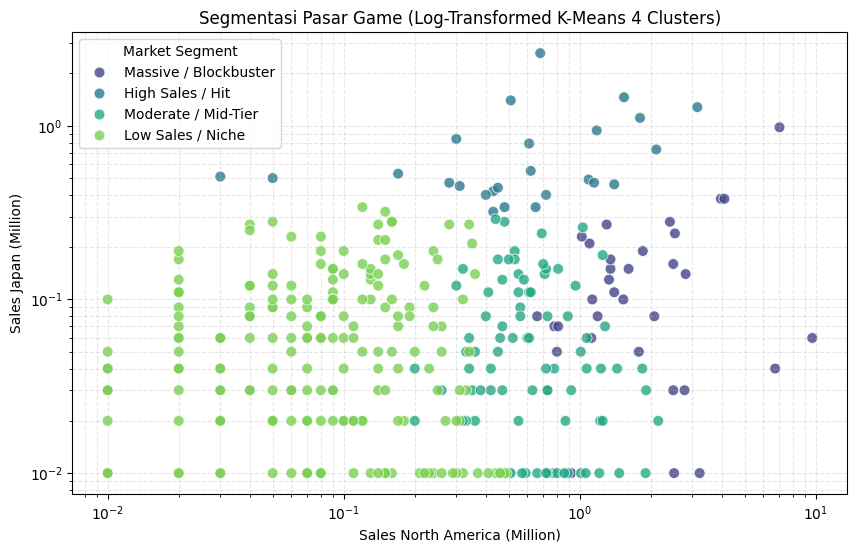

In [37]:
plt.figure(figsize=(10, 6))

# Scatter Plot: Sumbu X=Amerika, Sumbu Y=Jepang
sns.scatterplot(data=df, x='NA_Sales', y='JP_Sales', hue='Cluster_Label', 
                palette='viridis', s=60, alpha=0.8, hue_order=julukan[::-1]) # Order legend dibalik biar Sultan di atas

plt.title('Segmentasi Pasar Game (Log-Transformed K-Means 4 Clusters)')
plt.xlabel('Sales North America (Million)')
plt.ylabel('Sales Japan (Million)')

# Ubah skala visualisasi ke Log agar sebarannya terlihat jelas
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Market Segment')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

### Save Model

In [38]:
print("Menyimpan Model & Data...")

output_csv = '../dataset/data_with_cluster.csv'
df.to_csv(output_csv, index=False)

model_dir = '../backend/app/models'
os.makedirs(model_dir, exist_ok=True)

joblib.dump(kmeans, f'{model_dir}/model_kmeans.pkl')
joblib.dump(scaler, f'{model_dir}/scaler_cluster.pkl')

print(f"SUKSES! Data tersimpan di: {output_csv}")
print(f"Model tersimpan di: {model_dir}")

Menyimpan Model & Data...
SUKSES! Data tersimpan di: ../dataset/data_with_cluster.csv
Model tersimpan di: ../backend/app/models
